In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

In [2]:
class BondExpansionEstimator(nn.Module):
    def __init__(self, input_size, hidden_layers, check_weights = True):
        super(BondExpansionEstimator, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.check_weights = check_weights
        self.hidden1 = nn.Linear(input_size, hidden_layers[0])
        self.hidden2 = nn.Linear(hidden_layers[0], hidden_layers[1])
        self.hidden3 = nn.Linear(hidden_layers[1], 1)

    def forward(self, x):
        # Select data related to individual bonds
        # Data- 2D   seq x feat
        seq_len = x.shape[0]
        bond_data = x[:, 0:-1]
        bond_data = bond_data.view(-1, self.input_size)
        # Assume last column of data is bond weight (fraction of volume)
        vol_fracs = x[:, -1]
        # Check the bond weights are well normalized
        if self.check_weights:
            assert torch.abs(torch.sum(vol_fracs) - 1) < 1e-5 
        
        # Run all hidden layers
        out = torch.relu(self.hidden1(bond_data))
        out = torch.relu(self.hidden2(out))
        out = self.hidden3(out)
        out = out.view(-1, seq_len)
        # Sum all bonds according to their bond fractions
        summed = torch.sum(out*vol_fracs)
        return summed

class LatticeDistortionEstimator(nn.Module):
    def __init__(self, input_size):
        super(LatticeDistortionEstimator, self).__init__()
        self.input_size = input_size
        self.layer1 = nn.Linear(input_size, input_size)
        self.layer2 = nn.Linear(input_size, 1)

    def forward(self, x):
        # Run all hidden layers
        out = torch.relu(self.layer1(x))
        out = torch.sigmoid(self.layer2(out))

        return out

class CombinedModel(nn.Module):
    def __init__(self, model_a, model_b):
        super(CombinedModel, self).__init__()
        self.model_a = model_a
        self.model_b = model_b

    def forward(self, x1, x2):
        output_a = self.model_a(x1)
        output_b = self.model_b(x2)

        return output_a*output_b


In [5]:
def score_data(model, X_bond, X_struc, y):
    model.eval()
    with torch.no_grad():
        y_pred = []
        for x, x_struc in zip(X_bond, X_struc):
            if torch.cuda.is_available():
                x, x_struc = x.to('cuda'), x_struc.to('cuda')
            y_pred.append(model(x, x_struc).cpu())
        y_pred = torch.cat(y_pred)

    metric1 = mean_squared_error(y.numpy(), y_pred.numpy())
    metric2 = mean_absolute_error(y.numpy(), y_pred.numpy())
    metric3 = r2_score(y.numpy(), y_pred.numpy())
    metric4 = np.var(np.abs(y.numpy(), y_pred.numpy()))
    
    return [metric1, metric2, metric3, metric4]

## Test Use of Model with Fake Data

In [13]:
# Model Parameters
bond_input_size = 48
distortion_input_size = 4
hidden_layers = [20, 20]

# Training Parameters
learning_rate = 0.0001
num_epochs = 50

# Create an instance of the AdditiveSequentialModel
expansion_model = BondExpansionEstimator(bond_input_size, hidden_layers, check_weights=False)
distortion_model = LatticeDistortionEstimator(distortion_input_size)
tec_model = CombinedModel(expansion_model, distortion_model)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(tec_model.parameters(), lr=learning_rate)  # That's me!!
print("Number of parameters: ", sum(p.numel() for p in tec_model.parameters()))

# Generate random sequential data for training
data_size = 1500
seq_length = 5
test_bond_fracs = 0.3*torch.rand(data_size, seq_length, 1)
input_data1 = torch.rand(data_size, seq_length, bond_input_size)
input_data2 = torch.rand(data_size, distortion_input_size)+1
target_data =  2*torch.randn(data_size, 1)  # Start with noise
hidden_A = torch.rand(bond_input_size, 1) # Hidden model
hidden_B = torch.rand(distortion_input_size, 1) # Hidden model
perfect_lab = torch.ones(data_size, 1)  # Start with noise
for i in range(len(target_data)):
    target_data[i] = target_data[i] + torch.matmul( torch.matmul(input_data1[i,:,:], hidden_A).T, test_bond_fracs[i,:]) * torch.matmul(input_data2[i,:], hidden_B)
    perfect_lab[i] = torch.matmul( torch.matmul(input_data1[i,:,:], hidden_A).T, test_bond_fracs[i,:]) * torch.matmul(input_data2[i,:], hidden_B)
input_data1 = torch.cat((input_data1, test_bond_fracs), dim=2)

# Training loop
loss_log = []
for epoch in range(num_epochs):
    # Forward pass
    losses = []
    for in1, in2, y in zip(input_data1, input_data2, target_data):
        outputs = tec_model(in1, in2)
        loss = criterion(outputs, y)
    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Example of using the trained model for prediction
test_input1 = torch.randn(1, seq_length, bond_input_size+1)
test_input2 = torch.randn(1, distortion_input_size)
predicted_output = torch.zeros(data_size, 1)
for i in range(data_size):
    predicted_output[i] = tec_model(input_data1[i], input_data2[i])

AttributeError: module 'torch' has no attribute '_utils'

In [ ]:
# Results
print("Input1 shape:", test_input1.shape)
print("Input2 shape:", test_input2.shape)

plt.scatter(perfect_lab.numpy(), target_data.numpy())
plt.ylabel("Noisy val")
plt.xlabel("Perfect Label Val")
plt.show()

plt.scatter(target_data.numpy(), predicted_output.detach().numpy())
plt.xlabel("Noisy val")
plt.ylabel("Predicted Val")
plt.show()


## Now Train on Real Data with SGD

## Load in Data

In [ ]:
labels_df = pd.read_csv("labels/labels_reduced.csv", index_col=0)
features_bond_df = pd.read_csv("features/features_bond.csv", index_col=0)
features_struc_df = pd.read_csv("features/features_structure.csv", index_col=0)

# Choose Features
columns_all = features_bond_df.columns[2:-1].to_list()  # ALL FEATURES, exclude file names and bond volume fractions
feature_weights = features_bond_df[features_bond_df.columns[-1]].to_numpy()
struc_columns = features_struc_df.columns[2:].to_list()

# Copy over labels to each bond (just for correlation)
y = list()
combined_data = list()
weights = list()
struc_data = list()
labels_skipped = 0
max_length = 0
all_phases = set()
for idx in labels_df.index:
    phase = labels_df.loc[idx, 'phase_id']
    feat = features_bond_df[features_bond_df['structure_name'] == str(int(phase))+'_super.cif']  # Select all rows applicable to 
    feat_struc = features_struc_df[features_struc_df['structure_name'] == str(int(phase))+'_super.cif']
    if len(feat) > 0 and len(feat_struc) > 0:
        weights.append(torch.Tensor(feat['volume_fraction'].values).to(torch.float).view(len(feat),1))
        feat = feat[columns_all]
        feat['temperature'] = labels_df.loc[idx, "temperature"]  # add temperature as a feature
        max_length = max(max_length, len(feat))
        combined_data.append(torch.Tensor(feat.values).to(torch.float))
        feat_struc = feat_struc[struc_columns]
        try:
            struc_data.append(torch.Tensor(feat_struc.values).to(torch.float))
        except:
            print(feat_struc.values)
        y.append( labels_df.loc[idx, "thermal_expansion"] )
        all_phases.add(phase)
    else:
        print("Phases ", phase, " not found in features data")
        labels_skipped += 1

print("Total Number of Labels: ", len(y))
print("Skipped {} structures".format(labels_skipped))
print("Total Unique structures", len(all_phases))
print("Max Number of Bonds: ", max_length)
# Recast y as a torch tensor
y = torch.Tensor(y)
y = y.view(-1,1)

In [ ]:
# Make sure all weights are normalized
# TODO: figure out why this is necessary
for i in range(len(weights)):
    s = torch.sum(weights[i])
    if abs(s-1) > 1e-6:
        weights[i] = weights[i]/s

In [ ]:
# Build and Normalize X
X_mean = torch.mean(torch.cat(combined_data),dim=0)
X_std = torch.std(torch.cat(combined_data),dim=0)
X = []
for x,w in zip(combined_data, weights):
    X.append(torch.cat(((x-X_mean)/X_std, w), dim=1))

In [ ]:
# Build and Normalize X_struc
X_struc_mean = torch.mean(torch.cat(struc_data),dim=0)
X_struc_std = torch.std(torch.cat(struc_data),dim=0)
X_struc = []
for x in struc_data:
    X_struc.append(torch.Tensor((x-X_struc_mean)/X_struc_std) )
X_struc = torch.cat(X_struc)

In [ ]:
# Normalize Y
y_mean = torch.mean(y)
y_std = torch.std(y)
y = (y-y_mean)/y_std

In [ ]:
y_std

In [ ]:
y_mean

In [ ]:
# Save tensors to a file
torch.save({'X': X, 'y': y, 'X_struc': X_struc, 'X_mean':X_mean, 'X_std':X_std, 'X_struc_mean':X_struc_mean, 'X_struc_std':X_struc_std,'y_mean':y_mean, 'y_std':y_std}, 'features/data_tensors.pth')

## Create and Train Model

In [26]:
# Load tensors from the file
loaded_data = torch.load('features/data_tensors.pth')
X = loaded_data['X']
X_struc = loaded_data['X_struc']
y = loaded_data['y']

# Load Preprocessing Parameters
X_mean = loaded_data['X_mean']
X_std = loaded_data['X_std']
X_struc_mean = loaded_data['X_struc_mean']
X_struc_std = loaded_data['X_struc_std']
y_mean = loaded_data['y_mean']
y_std = loaded_data['y_std']
print("Number labels:", len(y))

num_bonds = 0
for x in X:
    num_bonds += len(x)
print("Total Number of Bonds: ", num_bonds)

Number labels: 1068
Total Number of Bonds:  3385536


In [27]:
# Model Parameters
bond_input_size = len(X[0][0])-1  # Don't count bond length weights
distortion_input_size = len(X_struc[0])
hidden_layers = [30, 30]

# Training Parameters
learning_rate = 0.0005
num_epochs = 80000
batch_size = 1  # True SGD due to data being varying length sequences
n_splits = 8
break_early = False
score_n_it = 1000  # Score every N epochs

# Set up Cross Validation with K-Folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Check GPU Availability
if torch.cuda.is_available():
    print("Available GPU Device:", torch.cuda.get_device_name(0))
else: 
    print("GPU not available, using CPU...")


Available GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU


## Perform k-fold cross-validation

In [28]:
loss_log = list()
train_scores = list()
test_scores = list()
fold_num = 0  # Tracking current fold

for train_index, test_index in kf.split(X):
    train_index = list(train_index)
    test_index = list(test_index)
    train_scores.append([])
    test_scores.append([])
    fold_num += 1
    
    # Create an instance of the model
    expansion_model = BondExpansionEstimator(bond_input_size, hidden_layers)
    distortion_model = LatticeDistortionEstimator(distortion_input_size)
    tec_model = CombinedModel(expansion_model, distortion_model)
    
    # Define a loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(expansion_model.parameters(), lr=learning_rate)  # That's me!!
    
    # Train on GPU
    if torch.cuda.is_available():
        tec_model = tec_model.to('cuda') 
    
    print("Starting K Fold {} out of {}".format(fold_num, n_splits))
    # Training loop
    losses = list()
    for epoch in range(num_epochs):
        # Sample one data point for SGD
        train_idx = random.choice(train_index)
        
        # Move training to GPU if available
        if torch.cuda.is_available():
            batch_X, batch_X_struc, batch_y = X[train_idx].to('cuda'), X_struc[train_idx].to('cuda'), y[train_idx].to('cuda')
        else:
            batch_X, batch_X_struc, batch_y = X[train_idx], X_struc[train_idx], y[train_idx]

        # Forward pass
        outputs = tec_model(batch_X, batch_X_struc)  
        loss = criterion(outputs, batch_y)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record loss to make convergence plots
        losses.append(loss.item())
        
        # Evaluate score every N epochs
        if (epoch + 1) % score_n_it == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses[-1000:]):.4f}')
            train_metrics = score_data(tec_model, [X[i] for i in train_index], [X_struc[i] for i in train_index], torch.cat([y[i] for i in train_index]))
            train_scores[-1].append(train_metrics)
            test_metrics = score_data(tec_model, [X[i] for i in test_index], [X_struc[i] for i in test_index], torch.cat([y[i] for i in test_index]))
            test_scores[-1].append(test_metrics)
            
    loss_log.append(losses)

    # Clear cache on GPU
    torch.cuda.empty_cache() 
    
    # If you only want to run once for speed
    if break_early:
        break
 

Starting K Fold 1 out of 8
Epoch [1000/80000], Loss: 0.9254
Epoch [2000/80000], Loss: 0.7813
Epoch [3000/80000], Loss: 0.7303
Epoch [4000/80000], Loss: 0.8265
Epoch [5000/80000], Loss: 0.8567
Epoch [6000/80000], Loss: 0.8197
Epoch [7000/80000], Loss: 0.7984
Epoch [8000/80000], Loss: 0.6605
Epoch [9000/80000], Loss: 0.6733
Epoch [10000/80000], Loss: 0.6517
Epoch [11000/80000], Loss: 0.6741
Epoch [12000/80000], Loss: 0.5957
Epoch [13000/80000], Loss: 0.6390
Epoch [14000/80000], Loss: 0.6035
Epoch [15000/80000], Loss: 0.6053
Epoch [16000/80000], Loss: 0.7154
Epoch [17000/80000], Loss: 0.7625
Epoch [18000/80000], Loss: 0.5151
Epoch [19000/80000], Loss: 0.5908
Epoch [20000/80000], Loss: 0.5680
Epoch [21000/80000], Loss: 0.5454
Epoch [22000/80000], Loss: 0.6647
Epoch [23000/80000], Loss: 0.6023
Epoch [24000/80000], Loss: 0.5853
Epoch [25000/80000], Loss: 0.5417
Epoch [26000/80000], Loss: 0.6299
Epoch [27000/80000], Loss: 0.5156
Epoch [28000/80000], Loss: 0.6104
Epoch [29000/80000], Loss: 0.5

In [29]:
# Report Number of Parameters
print("Number of parameters: ", sum(p.numel() for p in tec_model.parameters()))
n_sel = len(train_scores)  # Can plot metrics for an intermediate epoch if desired

# Calculate the average performance across all folds
train_scores = np.array(train_scores)
print("Original Data Variance: ", y_std.numpy()**2)

print("\nTRAINING R2: ", np.mean(train_scores[:,n_sel,2]))
print("TRAINING Mean Error [10-6/K]: ", np.mean(train_scores[:,n_sel,1])*y_std.numpy())
print("TRAINING Error Variance [10-6/K]: ", np.mean(train_scores[:,n_sel,3]*y_std.numpy()))
print("TRAINING MSE [10-12/K^2]: ", np.mean(train_scores[:,n_sel,0])*y_std.numpy()**2)

test_scores = np.array(test_scores)
print("\nTEST R2: ", np.mean(test_scores[:,n_sel,2]))
print("TEST Mean Error [10-6/K]: ", np.mean(test_scores[:,n_sel,1])*y_std.numpy())
print("TEST Error Variance [10-6/K]: ", np.mean(test_scores[:,n_sel,3]*y_std.numpy()))
print("TEST MSE [10-12/K^2]: ", np.mean(test_scores[:,n_sel,0])*y_std.numpy()**2)


Number of parameters:  2510
Original Data Variance:  56.142815

TRAINING R2:  0.30534022645284936
TRAINING Mean Error [10-6/K]:  4.320033426679181
TRAINING Error Variance [10-6/K]:  3.568444646004453
TRAINING MSE [10-12/K^2]:  38.95293903313927

TEST R2:  0.20172062911566754
TEST Mean Error [10-6/K]:  4.594315764867066
TEST Error Variance [10-6/K]:  3.5532465795459416
TEST MSE [10-12/K^2]:  44.61862253556245


# Plot Predictions for train set and Error

Train R2 Score:  0.5234429001116363
Test R2 Score:  0.2642046838407466


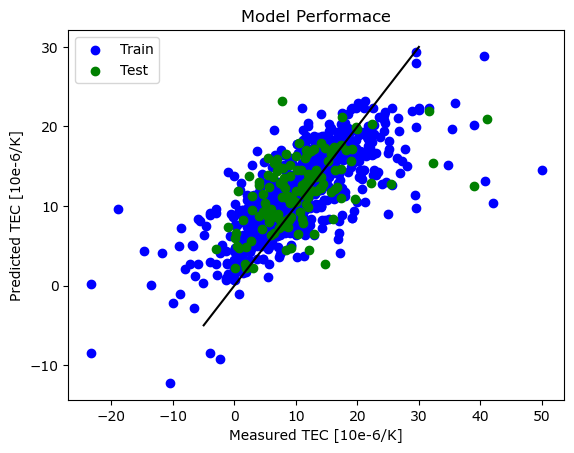

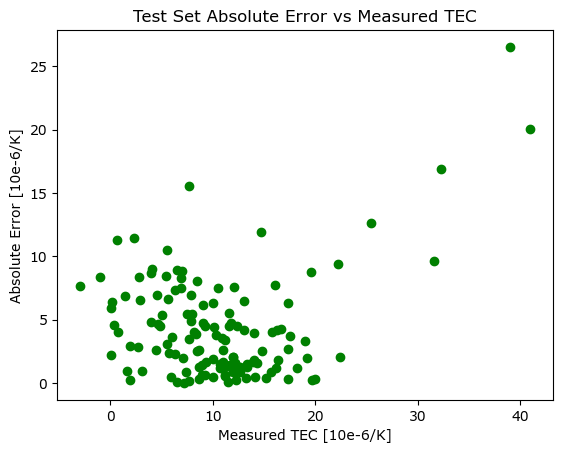

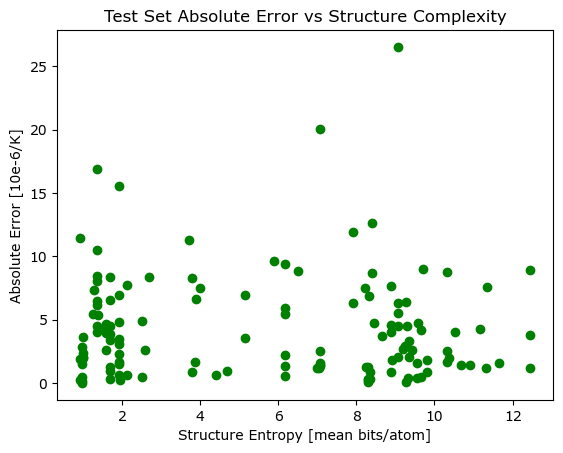

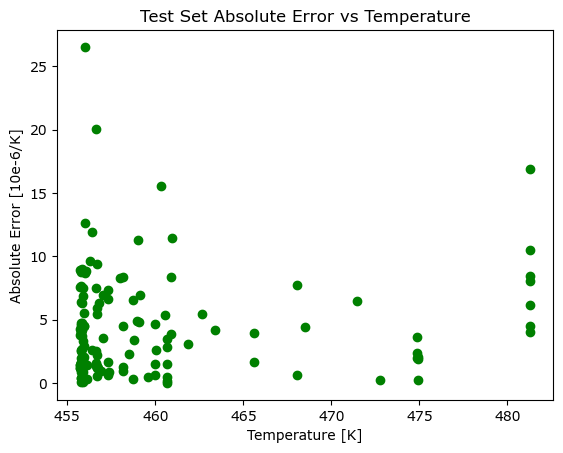

In [44]:
# Train Predicions
y_train = torch.cat([y[i] for i in train_index])
X_train = [X[i] for i in train_index]
X_struc_train = [X_struc[i] for i in train_index]
y_pred_train = []
for x, x_struc in zip(X_train, X_struc_train):
    if torch.cuda.is_available():
        x, x_struc = x.to('cuda'), x_struc.to('cuda')
    y_pred_train.append(tec_model(x, x_struc).cpu())
y_pred_train = torch.cat(y_pred_train)
# Test Predictions
y_test = torch.cat([y[i] for i in test_index])
X_test = [X[i] for i in test_index]
X_struc_test = [X_struc[i] for i in test_index]
y_pred_test = []
for x, x_struc in zip(X_test, X_struc_test):
    if torch.cuda.is_available():
        x, x_struc = x.to('cuda'), x_struc.to('cuda')
    y_pred_test.append(tec_model(x, x_struc).cpu())
y_pred_test = torch.cat(y_pred_test)

# Transform back
y_measure_train = (y_train*y_std)+y_mean
y_measure_test = (y_test*y_std)+y_mean
y_predict_train = (y_pred_train*y_std)+y_mean
y_predict_test = (y_pred_test*y_std)+y_mean


print("Train R2 Score: ", r2_score(y_train.numpy(), y_pred_train.detach().numpy()))
print("Test R2 Score: ", r2_score(y_measure_test.numpy(), y_predict_test.detach().numpy()))

# Plot data
plt.scatter(y_measure_train.numpy(), y_predict_train.detach().numpy(), color='blue')
plt.scatter(y_measure_test.numpy(), y_predict_test.detach().numpy(), color='green')
plt.legend(["Train", "Test"])
plt.xlabel("Measured TEC [10e-6/K]")
plt.ylabel("Predicted TEC [10e-6/K]")
plt.title("Model Performace")
plt.plot([-5, 30], [-5, 30], color='k')
plt.savefig("figs/model_scatter.png")
plt.show()

plt.scatter(y_measure_test.numpy(), np.abs(y_predict_test.detach().numpy()-y_measure_test.numpy()), color='green')
plt.title("Test Set Absolute Error vs Measured TEC")
plt.xlabel("Measured TEC [10e-6/K]")
plt.ylabel("Absolute Error [10e-6/K]")
plt.savefig("figs/error_vs_tec.png")
plt.show()

entropy_mean = X_struc_mean[0]
entropy_std = X_struc_std[0]
complexity = [(entropy_std*i[0]+entropy_mean) for i in X_struc_test]
plt.scatter(complexity, np.abs(y_predict_test.detach().numpy()-y_measure_test.numpy()), color='green')
plt.title("Test Set Absolute Error vs Structure Complexity")
plt.xlabel("Structure Entropy [mean bits/atom]")
plt.ylabel("Absolute Error [10e-6/K]")
plt.savefig("figs/complexity_vs_tec.png")
plt.show()

temp_mean = X_mean[-1]
temp_std = X_std[-1]
temperatures = [(temp_std*i[0][-1]+temp_mean) for i in X_test]
plt.scatter(temperatures, np.abs(y_predict_test.detach().numpy()-y_measure_test.numpy()), color='green')
plt.title("Test Set Absolute Error vs Temperature")
plt.xlabel("Temperature [K]")
plt.ylabel("Absolute Error [10e-6/K]")
plt.savefig("figs/temperature_vs_tec.png")
plt.show()

# Plot Error Convergence for train and test

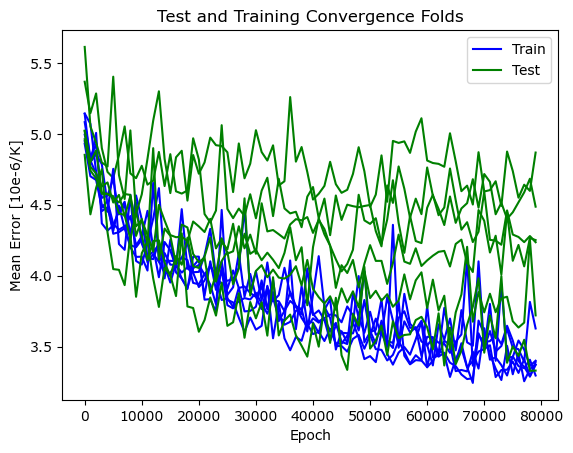

In [31]:
plt.plot( np.arange(len(train_scores[0, :, 1]))*score_n_it, train_scores[0, :, 1]*y_std.numpy(), 'b')
plt.plot(np.arange(len(test_scores[0, :, 1]))*score_n_it, test_scores[0, :, 1]*y_std.numpy(), 'g')
plt.legend(['Train', 'Test'])
for i in range(1,6):
    plt.plot( np.arange(len(train_scores[i, :, 1]))*score_n_it, train_scores[i, :, 1]*y_std.numpy(), 'b')
for i in range(1,6):
    plt.plot( np.arange(len(test_scores[i, :, 1]))*score_n_it, test_scores[i, :, 1]*y_std.numpy(), 'g')
plt.xlabel('Epoch')
plt.ylabel('Mean Error [10e-6/K]')
plt.title('Test and Training Convergence Folds')
plt.savefig("figs/test_train_convergence.png")
plt.show()

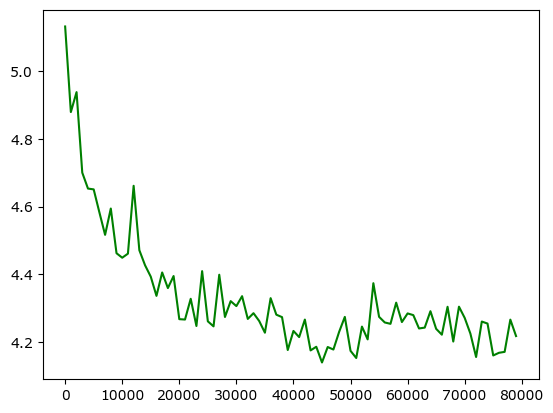

In [32]:
plt.plot(np.arange(len(test_scores[0, :, 1]))*score_n_it, np.mean(test_scores[:, :, 1], axis=0)*y_std.numpy(), 'g')
plt.show()

# Plot Loss over each set of Batches 

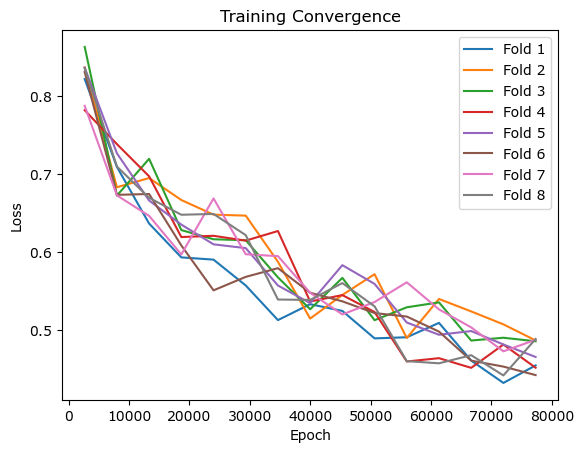

In [33]:
k_smooth = 15
loss_log = np.array(loss_log)
smoothed_loss = []
avg_epoch = []
n_smooth = int(max(loss_log.shape)/k_smooth) - 1
for i in range(k_smooth):
    smoothed_loss.append(np.mean(loss_log[:, i*n_smooth:(i+1)*n_smooth], axis=1))
    avg_epoch.append((i+0.5)*n_smooth)
smoothed_loss = np.array(smoothed_loss)

plt.plot(avg_epoch, smoothed_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Convergence')
plt.legend(['Fold {}'.format(i) for i in range(1,n_splits+1)])
plt.savefig("figs/convergence.png")
plt.show()

In [34]:
for name, param in tec_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

model_a.hidden1.weight tensor([[-3.6752e-01, -9.7369e-03, -5.2299e-01,  ..., -3.1253e-01,
          1.4643e-01, -1.5232e-01],
        [ 1.9324e-01,  1.8362e-01,  1.2358e-01,  ..., -5.7285e-02,
         -6.5071e-01, -3.7972e-01],
        [-3.4003e-01, -3.0647e-02, -4.5266e-01,  ...,  1.9744e-01,
         -6.0656e-01,  4.5732e-01],
        ...,
        [-1.9444e-01,  1.6479e-01, -2.2818e-01,  ..., -4.7430e-01,
         -1.5551e-04, -6.6328e-01],
        [-4.0742e-01, -4.7568e-02, -4.4337e-01,  ...,  5.1379e-01,
          7.5639e-01, -2.6491e-01],
        [-9.4223e-02, -5.3960e-02, -9.3633e-02,  ...,  2.1223e-01,
          2.0623e-02,  2.6155e-01]], device='cuda:0')
model_a.hidden1.bias tensor([ 0.0970, -0.0845,  0.1563, -0.2790,  0.0690,  0.0971, -0.4929, -0.1189,
        -0.1797, -0.0549,  0.1305, -0.1786, -0.4086,  0.3920,  0.2438, -0.2047,
        -0.2526, -0.1295,  0.0016, -0.2090, -0.2458, -0.0725,  0.0400, -0.2659,
        -0.1371, -0.0383,  0.3394, -0.1344,  0.1156, -0.1408], devi